In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '../data/extracted_features/combined_NLP/maria/'

NUM_TESTS = 100

HIDDEN_DIM0 = 183
NUM_LAYERS0 = 1
BIDIRECTIONAL = False
LEARNING_RATE0 =  0.011095843396210794
MOMENTUM0= 0.488375994822428
DECAY_FACTOR0 = 0.18991100364301827
EPOCH0 = 4

HIDDEN_DIM1 = 364
NUM_LAYERS1 = 1
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.015103711963967328
MOMENTUM1= 0.2094525986367598
DECAY_FACTOR1 =  0.3093059390000923
EPOCH1 = 2

HIDDEN_DIM2 = 197
NUM_LAYERS2 = 2
ACTIVATION2 = torch.relu
LEARNING_RATE2 =  0.030727178086089976
MOMENTUM2= 0.5314758594296131
DECAY_FACTOR2 =  0.7632100704986595
EPOCH2 = 2

# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, num_layers = NUM_LAYERS0,
                          bidirectional = BIDIRECTIONAL, learning_rate = LEARNING_RATE0,
                          momentum = MOMENTUM0, decay_factor = DECAY_FACTOR0)
        model.learn(X_train, y_train, epochs=EPOCH0)
        
        # evaluate
        running_acc += model.get_accuracy(X_test, y_test)
        running_auc += model.get_auc(X_test, y_test)
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #model.plot_CIs(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [4]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]


# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


In [5]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

0.8002871410736584
0.842398288819204


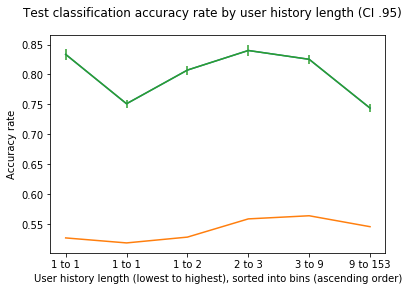

In [6]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        running_acc += baseline.get_accuracy(torch.Tensor(X_test), torch.Tensor(y_test))
        running_auc += baseline.get_auc(torch.Tensor(X_test), torch.Tensor(y_test))
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test), X_hist_len_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_seq_tfidf_test = np.load(TFIDF_DIR + 'X_seq_tfidf_test.npz')
X_hist_len_test = [ torch.Tensor(X_seq_tfidf_test[file]).shape[0] for file in X_seq_tfidf_test.files]


# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train_glove = np.load(GLOVE_DIR + 'y_train.npy')
y_test_glove = np.load(GLOVE_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove


In [10]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

0.7958926342072412
0.8486038873269897


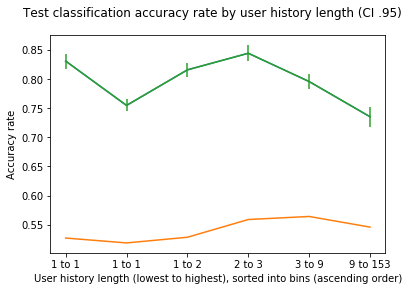

In [11]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        running_acc += baseline.get_accuracy(torch.Tensor(X_test), torch.Tensor(y_test))
        running_auc += baseline.get_auc(torch.Tensor(X_test), torch.Tensor(y_test))
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test), X_hist_len_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [13]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove

In [14]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

0.79167290886392
0.8463806025627164


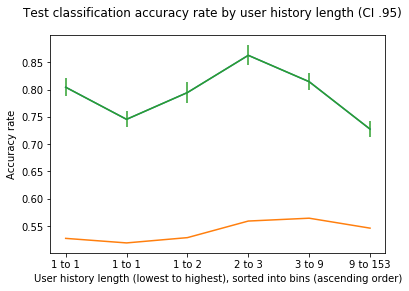

In [15]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)



